In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from torch import optim

In [2]:
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        
        # load a standard VGG19 from torchvision
        vgg_pretrained = models.vgg19(pretrained=True).features
        
        self.conv1_1 = vgg_pretrained[0] 
        self.conv1_2 = vgg_pretrained[2] 
        self.pool1   = vgg_pretrained[4]

        self.conv2_1 = vgg_pretrained[5]
        self.conv2_2 = vgg_pretrained[7]
        self.pool2   = vgg_pretrained[9]

        self.conv3_1 = vgg_pretrained[10]
        self.conv3_2 = vgg_pretrained[12]
        self.conv3_3 = vgg_pretrained[14]
        self.conv3_4 = vgg_pretrained[16]
        self.pool3   = vgg_pretrained[18]

        self.conv4_1 = vgg_pretrained[19]
        self.conv4_2 = vgg_pretrained[21]
        self.conv4_3 = vgg_pretrained[23]
        self.conv4_4 = vgg_pretrained[25]
        self.pool4   = vgg_pretrained[27]

        self.conv5_1 = vgg_pretrained[28]
        self.conv5_2 = vgg_pretrained[30]
        self.conv5_3 = vgg_pretrained[32]
        self.conv5_4 = vgg_pretrained[34]
        self.pool5   = vgg_pretrained[36]

        # Freeze parameters
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1']  = self.pool1(out['r12'])
        
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2']  = self.pool2(out['r22'])
        
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3']  = self.pool3(out['r34'])
        
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4']  = self.pool4(out['r44'])
        
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5']  = self.pool5(out['r54'])
        
        return [out[key] for key in out_keys]


# Gram Matrix, Gram Loss

class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.size()
        F_ = input.view(b, c, h*w)
        G = torch.bmm(F_, F_.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        return nn.MSELoss()(GramMatrix()(input), target)



# Pre/Post Processing

img_size = 512
prep = transforms.Compose([
    transforms.Resize(img_size), 
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]),  # BGR
    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], std=[1,1,1]),
    transforms.Lambda(lambda x: x.mul_(255)),
])

postpa = transforms.Compose([
    transforms.Lambda(lambda x: x.mul_(1./255)),
    transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], std=[1,1,1]),
    transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]),  # BGR -> RGB
])
postpb = transforms.Compose([transforms.ToPILImage()])

def postp(tensor):
    t = postpa(tensor)
    t[t>1] = 1
    t[t<0] = 0
    return postpb(t)

# use 800px for the high-resolution pass.
img_size_hr = 800
prep_hr = transforms.Compose([
    transforms.Resize(img_size_hr),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]),  
    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], std=[1,1,1]),
    transforms.Lambda(lambda x: x.mul_(255)),
])



# Main function for style transfer

def run_style_transfer(content_link, 
                       style_link, 
                       max_iter=500,
                       max_iter_hr=200,
                       show_iter=50):
    """
    Args:
        content_link (str): Local file path (or URL) of the content image
        style_link   (str): Local file path (or URL) of the style image
        max_iter     (int): Iterations for the 512px pass
        max_iter_hr  (int): Iterations for the 800px pass
        show_iter    (int): Print out loss every `show_iter` steps

    Returns:
        out_img_lr (PIL Image): 512px stylized image
        out_img_hr (PIL Image): 800px stylized image
    """
    
    # 1) Load VGG from torchvision
    vgg = VGG()
    if torch.cuda.is_available():
        vgg.cuda()

 
    # 2) Fetch images (local or URL)
    def fetch_image(url_or_path):
        if url_or_path.startswith('http://') or url_or_path.startswith('https://'):
            response = requests.get(url_or_path)
            img = Image.open(BytesIO(response.content))
        else:
            img = Image.open(url_or_path)
        return img.convert('RGB')

    style_pil   = fetch_image(style_link)
    content_pil = fetch_image(content_link)


    # 3) Preprocess images @ 512px
    style_torch   = prep(style_pil)
    content_torch = prep(content_pil)

    if torch.cuda.is_available():
        style_torch   = style_torch.unsqueeze(0).cuda()
        content_torch = content_torch.unsqueeze(0).cuda()
    else:
        style_torch   = style_torch.unsqueeze(0)
        content_torch = content_torch.unsqueeze(0)

    style_var   = torch.autograd.Variable(style_torch)
    content_var = torch.autograd.Variable(content_torch)


    # 4) Layers and losses
    style_layers   = ['r11','r21','r31','r41','r51']
    content_layers = ['r42']
    loss_layers    = style_layers + content_layers

    loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
    if torch.cuda.is_available():
        loss_fns = [fn.cuda() for fn in loss_fns]

    style_weights   = [1e3 / n**2 for n in [64,128,256,512,512]]
    content_weights = [1e0]
    weights         = style_weights + content_weights


    # 5) Compute style/content targets
    style_targets = [GramMatrix()(A).detach() for A in vgg(style_var, style_layers)]
    content_targets = [A.detach() for A in vgg(content_var, content_layers)]
    targets = style_targets + content_targets

    # 6) Initialize output image
    opt_img = torch.autograd.Variable(content_var.data.clone(), requires_grad=True)


    # 7) Optimize at 512px
    optimizer = optim.LBFGS([opt_img])
    n_iter = [0]

    while n_iter[0] <= max_iter:
        def closure():
            optimizer.zero_grad()
            out = vgg(opt_img, loss_layers)
            layer_losses = [weights[a] * loss_fns[a](A, targets[a]) 
                            for a, A in enumerate(out)]
            loss = sum(layer_losses)
            loss.backward()
            n_iter[0] += 1
            if n_iter[0] % show_iter == (show_iter - 1):
                print(f'Iteration: {n_iter[0] + 1}, loss: {loss.item()}')
            return loss
        optimizer.step(closure)

    out_img_lr = postp(opt_img.data[0].cpu())


    # 8) High-resolution pass @ 800px
    style_torch_hr   = prep_hr(style_pil)
    content_torch_hr = prep_hr(content_pil)
    if torch.cuda.is_available():
        style_torch_hr   = style_torch_hr.unsqueeze(0).cuda()
        content_torch_hr = content_torch_hr.unsqueeze(0).cuda()
    else:
        style_torch_hr   = style_torch_hr.unsqueeze(0)
        content_torch_hr = content_torch_hr.unsqueeze(0)

    style_var_hr   = torch.autograd.Variable(style_torch_hr)
    content_var_hr = torch.autograd.Variable(content_torch_hr)

    # Upsample previous low-res result
    opt_img_hr_data = prep_hr(out_img_lr).unsqueeze(0)
    if torch.cuda.is_available():
        opt_img_hr_data = opt_img_hr_data.cuda()

    opt_img_hr = torch.autograd.Variable(opt_img_hr_data, requires_grad=True)

    # Recompute targets for HR images
    style_targets_hr   = [GramMatrix()(A).detach() for A in vgg(style_var_hr, style_layers)]
    content_targets_hr = [A.detach() for A in vgg(content_var_hr, content_layers)]
    targets_hr = style_targets_hr + content_targets_hr

    # Optimize at 800px
    optimizer_hr = optim.LBFGS([opt_img_hr])
    n_iter_hr = [0]

    while n_iter_hr[0] <= max_iter_hr:
        def closure_hr():
            optimizer_hr.zero_grad()
            out_hr = vgg(opt_img_hr, loss_layers)
            layer_losses_hr = [weights[a] * loss_fns[a](A, targets_hr[a])
                               for a, A in enumerate(out_hr)]
            loss_hr = sum(layer_losses_hr)
            loss_hr.backward()
            n_iter_hr[0] += 1
            if n_iter_hr[0] % show_iter == (show_iter - 1):
                print(f'HR Iteration: {n_iter_hr[0] + 1}, loss: {loss_hr.item()}')
            return loss_hr
        optimizer_hr.step(closure_hr)

    out_img_hr = postp(opt_img_hr.data[0].cpu())

    # Show or return final images
    plt.figure(figsize=(7, 7))
    plt.imshow(out_img_lr)
    plt.title(f'Low-Resolution Result ({img_size}px)')
    plt.show()

    plt.figure(figsize=(9, 9))
    plt.imshow(out_img_hr)
    plt.title(f'High-Resolution Result ({img_size_hr}px)')
    plt.show()

    return out_img_lr, out_img_hr


In [3]:
def fetch_image(url_or_path):
    """Fetch an image from a local path or an HTTP/HTTPS URL."""
    if url_or_path.startswith('http://') or url_or_path.startswith('https://'):
        response = requests.get(url_or_path)
        img = Image.open(BytesIO(response.content))
    else:
        img = Image.open(url_or_path)
    return img.convert('RGB')

def display_images(content_link, style_link, out_hr):
    """
    Displays the content image, style image, and final stylized image
    side by side in a single row of subplots.

    Args:
        content_link (str): File path or URL for the content image
        style_link   (str): File path or URL for the style image
        out_hr       (PIL.Image): The final stylized image
    """
    # Fetch the content and style images from local path or URL
    content_img = fetch_image(content_link)
    style_img   = fetch_image(style_link)
    
    # out_hr is already a PIL Image, so we can use it directly
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(content_img)
    axes[0].set_title("Content Image")
    axes[0].axis("off")
    
    axes[1].imshow(style_img)
    axes[1].set_title("Style Image")
    axes[1].axis("off")
    
    axes[2].imshow(out_hr)
    axes[2].set_title("Result Image")
    axes[2].axis("off")
    
    plt.tight_layout()
    plt.show()


def display_images(content_link, style_link, out_hr):
    """
    Displays the content image, style image, and final stylized image
    side by side in a single row of subplots.

    Args:
        content_link (str): File path or URL for the content image
        style_link   (str): File path or URL for the style image
        out_hr       (PIL.Image): The final stylized image
    """
    # Fetch the content and style images from local path or URL
    content_img = fetch_image(content_link)
    style_img   = fetch_image(style_link)
    
    # out_hr is already a PIL Image, so we can use it directly
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(content_img)
    axes[0].set_title("Content Image")
    axes[0].axis("off")
    
    axes[1].imshow(style_img)
    axes[1].set_title("Style Image")
    axes[1].axis("off")
    
    axes[2].imshow(out_hr)
    axes[2].set_title("Result Image")
    axes[2].axis("off")
    
    plt.tight_layout()
    plt.show()

/Users/amitchaubey/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/amitchaubey/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Iteration: 50, loss: 8253.4609375
Iteration: 100, loss: 5187.12890625
Iteration: 150, loss: 4457.67578125
Iteration: 200, loss: 4136.27734375
Iteration: 250, loss: 3957.13037109375
Iteration: 300, loss: 3849.11181640625
Iteration: 350, loss: 3772.657470703125
Iteration: 400, loss: 3717.1923828125
Iteration: 450, loss: 3675.53076171875
Iteration: 500, loss: 3643.0322265625
HR Iteration: 50, loss: 4325.5458984375
HR Iteration: 100, loss: 3371.17578125
HR Iteration: 150, loss: 3051.878173828125
HR Iteration: 200, loss: 2886.223388671875


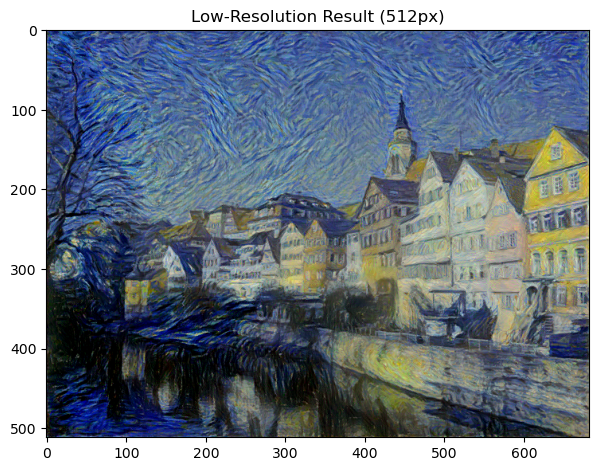

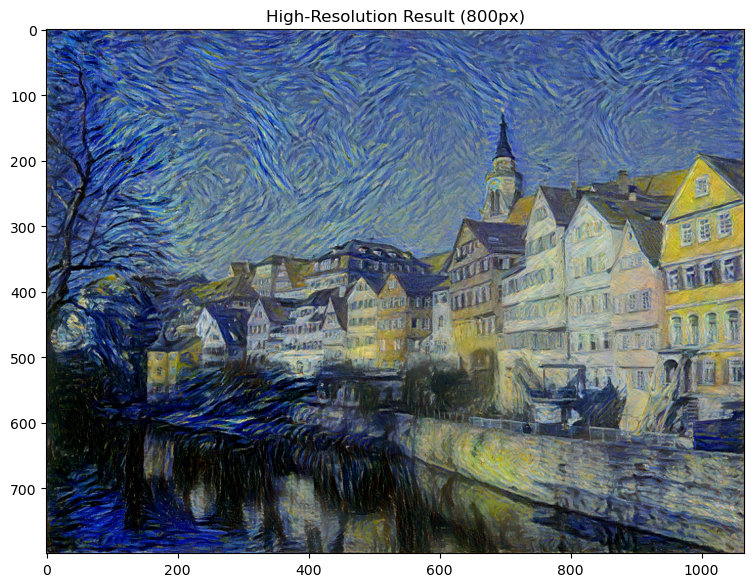

In [4]:
content_link = "/Users/amitchaubey/neural-style-transfer/pics/Tuebingen_Neckarfront.jpg"
style_link   = "/Users/amitchaubey/neural-style-transfer/paintings/vangogh_starry_night.jpg"

out_lr, out_hr = run_style_transfer(
    content_link=content_link,
    style_link=style_link,
    max_iter=500,       # optional
    max_iter_hr=200,    # optional
    show_iter=50        # optional
)

out_hr.save("final_stylized.png")